In [17]:
import cv2
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from scipy.spatial import distance
import random

%matplotlib inline


- objects count not correlated with area (objects/background) [TODO]
- randomized shapes? [TODO]
- randomized placement
- no overlaps
- what else?
- random color for objects


In [18]:


class GenerateImagesWithObjects:
    def __init__(self, 
                 obj_count_range=range(1, 50),
                 obj_size_range=(5, 15),
                 obj_distance_range=(5,20),
                 distribiuton='uniform',
                 image_shape=(150, 150, 3),
                 edge_dist=20,  
                 background='white',
                 area_filling=0.1,
                 black_and_white=False
                ):
        
        self.obj_count_range = obj_count_range
        self.obj_size_range = obj_size_range
        self.obj_distance_range = obj_distance_range
        self.distribiuton = distribiuton
        self.image_shape = image_shape
        self.edge_dist = edge_dist
        self.background = background
        self.black_and_white = black_and_white
        self.color_shape = 3
        self.area_filling = area_filling
        if self.black_and_white:
            self.image_shape=self.image_shape[:2]
            self.color_shape = 1
            
        
    @staticmethod    
    def _circles_are_overlapping(circle1, circle2):
        x0, y0, r0 = circle1
        x1, y1, r1 = circle2
        if circle1 == circle2:
            return True
        return abs(r0-r1)^2 <= ((x0-x1)^2 + (y0-y1)^2 <= (r0 + r1)^2)
    
    def _random_color(self):
        r = np.random.randint(20, 220, size=(self.color_shape), dtype=int)
        r = (132,132,132)
        return tuple([int(i) for i in r])



    def _circles_are_distant(self, circle1, circle2):  
        x0, y0, r0 = circle1
        x1, y1, r1 = circle2
        dst = distance.euclidean((x0,y0),(x1,y1)) - (r0 + r1)
        return dst>np.random.randint(*self.obj_distance_range)
    
    
    def _can_place_circle(self, circles_drawn, new_circle):
        x,y,r = new_circle
        canvas_shape = self.image_shape[1]
        if not(
        (0 <= x - r <= canvas_shape) and \
        (0 <= y - r <= canvas_shape) and \
        (0 <= x + r <= canvas_shape) and \
        (0 <= y + r <= canvas_shape)
        ):
            return False # circle is not overlapping with cnavas edge   
        return all([self._circles_are_distant(new_circle, c_on_canvas) for c_on_canvas in circles_drawn])
    
    
    
    def _get_random_circle(self):
        if self.distribiuton == 'uniform':
            x = np.random.randint(self.edge_dist, self.image_shape[0] - self.edge_dist)
            y = np.random.randint(self.edge_dist, self.image_shape[0] - self.edge_dist)
            r = np.random.randint(*self.obj_size_range) 
            
        return x,y,r
    
    def _generate_N_circle_radiuses_with_same_sum_of_areas(self, n_circles):
        rows, columns = self.image_shape[:2]
        canvas_size = rows  * columns
        n_circles = np.random.rand(n_circles)
        factor = np.sqrt((canvas_size * self.area_filling / np.pi) / np.sum(n_circles**2))
        good_circles_radiuses = n_circles * factor  
        return good_circles_radiuses

    
    def _get_canvas(self):    
        if self.background == 'noise':
            canvas = np.random.randint(1, 255, size=self.image_shape, dtype='uint8')
        elif self.background == 'white':
            canvas = np.ones(shape=self.image_shape, dtype='uint8')
        return canvas
    
                    
    def generate_image(self, nr_objects):

        canvas = self._get_canvas()
        if nr_objects == 0:
            return canvas/255.0

        circles_drawn = []
        radiuses = self._generate_N_circle_radiuses_with_same_sum_of_areas(nr_objects)
        x = y = r = None
        emergency_counter = 0
        for r in radiuses:
            random_color = self._random_color()
            x,y,_ = self._get_random_circle()
            while not self._can_place_circle(circles_drawn, (x, y, r)):
                x,y,_ = self._get_random_circle()    
                emergency_counter+=1
                if emergency_counter>100000:
                    print('ERROR EMERGENCY EXIT')
                    break
            x, y, r = int(x), int(y), int(r)
            cv2.circle(canvas, (x,y),r, random_color, -1)
            circles_drawn.append((x,y,r))
            
                
        return canvas/255.0
    
    
    def _generate_batch_of_images(self, batch_size=32):
        batch = []
        for _ in range(batch_size):
            target_y = random.randint(nr_of_objecs_range)
            batch.append(self.generate_image)
        
        return np.concatenate(batch)
    
    
    def image_generator(self, nr_of_objecs_range=range(1,15), batch_size=32):
        while True:
            batch = []
            ys = []
            for _ in range(batch_size):
                target_y = random.randint(nr_of_objecs_range[0], nr_of_objecs_range[-1])
                batch.append(np.expand_dims(self.generate_image(target_y), 0))
                ys.append(target_y)
            yield (np.concatenate(batch), np.array(ys).reshape(-1, 1))
        
    
    

                
                

In [19]:
from keras.layers import Convolution2D, Activation, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from keras import backend as K
K.set_image_dim_ordering('tf')
from keras.layers import Layer
from keras.optimizers import Adam
from keras.layers import ZeroPadding2D, Dropout
class Round(Layer):

    def __init__(self, **kwargs):
        super(Round, self).__init__(**kwargs)

    def get_output(self, train=False):
        X = self.get_input(train)
        return K.round(X)

    def get_config(self):
        config = {"name": self.__class__.__name__}
        base_config = super(Round, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def create_model(img_rows=150, img_cols=150):
    model = Sequential()
    model.add(Convolution2D(64, 3, 3, input_shape=(img_rows, img_cols, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(64, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(64, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dense(1))
#     model.add(Round())

    return model


def VGG_16(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(150,150,3)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    return model

Using Theano backend.
Using gpu device 0: GeForce GTX 1070 (CNMeM is enabled with initial size: 40.0% of memory, cuDNN 5105)


In [20]:
model = create_model()
# model = VGG_16()
adam = Adam(lr=0.001)
model.compile(
    loss='mean_absolute_percentage_error',
    optimizer=adam,
    metrics=['mean_absolute_percentage_error']
)


In [21]:
go = GenerateImagesWithObjects()
ig = go.image_generator(batch_size=64)
history_model = model.fit_generator(ig, 750, nb_epoch=1000)


# plt.imshow((go.generate_image(3)))

Epoch 1/1000
768/750 [==============================] - 3s - loss: 60.4692 - mean_absolute_percentage_error: 60.4692     

/home/i008/anaconda2/lib/python2.7/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '



Epoch 2/1000
768/750 [==============================] - 3s - loss: 33.9430 - mean_absolute_percentage_error: 33.9430     
Epoch 3/1000
768/750 [==============================] - 3s - loss: 21.1753 - mean_absolute_percentage_error: 21.1753     
Epoch 4/1000
768/750 [==============================] - 3s - loss: 13.5385 - mean_absolute_percentage_error: 13.5385     
Epoch 5/1000
768/750 [==============================] - 3s - loss: 10.2239 - mean_absolute_percentage_error: 10.2239     
Epoch 6/1000
768/750 [==============================] - 3s - loss: 8.7050 - mean_absolute_percentage_error: 8.7050     
Epoch 7/1000
768/750 [==============================] - 3s - loss: 8.2459 - mean_absolute_percentage_error: 8.2459     
Epoch 8/1000
768/750 [==============================] - 3s - loss: 6.6363 - mean_absolute_percentage_error: 6.6363     
Epoch 9/1000
768/750 [==============================] - 3s - loss: 8.5519 - mean_absolute_percentage_error: 8.5519     
Epoch 10/1000
768/750 [========

KeyboardInterrupt: 

In [9]:
go = GenerateImagesWithObjects()
g = go.image_generator()
# x, y = g.next()


model.predict(np.expand_dims(go.generate_image(30), 0))

array([[ 25.72902679]], dtype=float32)

In [16]:
w = model.layers[6]

In [11]:
from keras.models import save_model

In [22]:
# from keras.models import load_model

# model = load_model('model_dump.keras')


layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_dict

{'activation_1': <keras.layers.core.Activation at 0x7f922d95a810>,
 'activation_2': <keras.layers.core.Activation at 0x7f922d909450>,
 'activation_3': <keras.layers.core.Activation at 0x7f922d89ba10>,
 'activation_4': <keras.layers.core.Activation at 0x7f922d85ffd0>,
 'activation_5': <keras.layers.core.Activation at 0x7f922d7bbad0>,
 'activation_6': <keras.layers.core.Activation at 0x7f922d7c2450>,
 'convolution2d_1': <keras.layers.convolutional.Convolution2D at 0x7f9252752e50>,
 'convolution2d_2': <keras.layers.convolutional.Convolution2D at 0x7f922d957790>,
 'convolution2d_3': <keras.layers.convolutional.Convolution2D at 0x7f922d90ed50>,
 'convolution2d_4': <keras.layers.convolutional.Convolution2D at 0x7f922d8cc350>,
 'dense_1': <keras.layers.core.Dense at 0x7f922d7b7c90>,
 'dense_2': <keras.layers.core.Dense at 0x7f922d7c2b90>,
 'dense_3': <keras.layers.core.Dense at 0x7f922d7c9ad0>,
 'flatten_1': <keras.layers.core.Flatten at 0x7f922d873910>,
 'maxpooling2d_1': <keras.layers.pooli

0
1
2
3
4
5
6
7
8
9


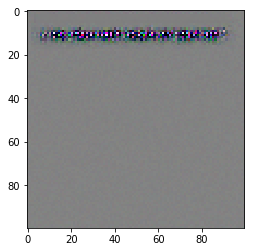

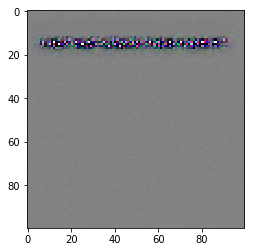

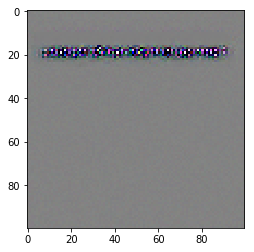

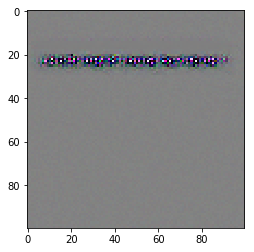

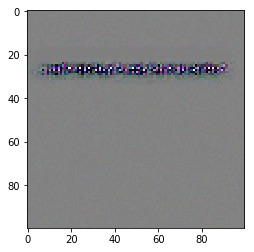

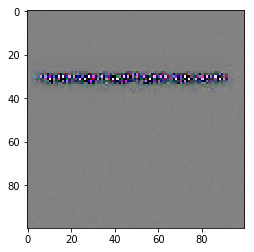

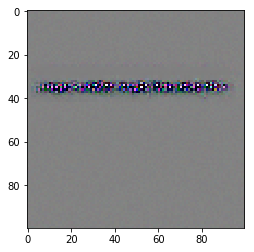

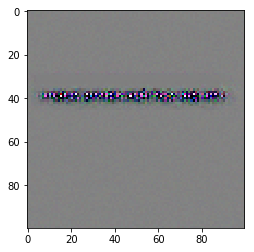

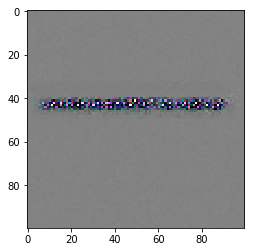

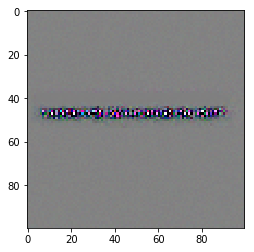

In [32]:
for i in range(0,10):
    print(i)

    layer_name = 'convolution2d_3'
    filter_index = i
    layer_output = layer_dict[layer_name].output

    first_layer = model.layers[0]
    input_img = first_layer.input

    loss = K.mean(layer_output[:, filter_index,:, :])
    grads = K.gradients(loss, input_img)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([input_img], [loss, grads])

    input_img_data = np.random.random((1,100, 100,3)) * 20

    for i in range(100):
        loss_value, grads_value = iterate([input_img_data])
    #     print(loss_value, grads_value)
        input_img_data += grads_value * 1.
    A = deprocess_image(input_img_data[0])    
    plt.figure()
    plt.imshow(A)

In [25]:
for i in range(0,32):

    layer_name = 'convolution2d_9'
    filter_index = i
    layer_output = layer_dict[layer_name].output

    first_layer = model.layers[0]
    input_img = first_layer.input

    loss = K.mean(layer_output[:, filter_index,:, :])
    grads = K.gradients(loss, input_img)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([input_img], [loss, grads])

    input_img_data = np.random.random((1,150, 150,3)) * 20 + 128

    for i in range(100):
        loss_value, grads_value = iterate([input_img_data])
    #     print(loss_value, grads_value)
        input_img_data += grads_value * 1.
    A = deprocess_image(input_img_data[0])    
    plt.figure()
    plt.imshow(A)

KeyError: 'convolution2d_9'

In [166]:
A[:,0].shape

(150, 3)

In [143]:
# input_image_data.shape


In [24]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
#     x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [145]:
A = deprocess_image(input_img_data[0])

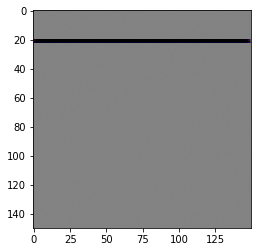

In [146]:
plt.imshow(A)

In [13]:
layer_dict

{'activation_10': <keras.layers.core.Activation at 0x7fb580fe8990>,
 'activation_11': <keras.layers.core.Activation at 0x7fb5809bc690>,
 'activation_12': <keras.layers.core.Activation at 0x7fb5759d9cd0>,
 'activation_9': <keras.layers.core.Activation at 0x7fb581064690>,
 'convolution2d_5': <keras.layers.convolutional.Convolution2D at 0x7fb580edcf90>,
 'convolution2d_6': <keras.layers.convolutional.Convolution2D at 0x7fb58105a4d0>,
 'dense_7': <keras.layers.core.Dense at 0x7fb582626b10>,
 'dense_8': <keras.layers.core.Dense at 0x7fb5809bc6d0>,
 'dense_9': <keras.layers.core.Dense at 0x7fb5759e2d90>,
 'flatten_3': <keras.layers.core.Flatten at 0x7fb580fe8ed0>,
 'maxpooling2d_5': <keras.layers.pooling.MaxPooling2D at 0x7fb580ee4850>,
 'maxpooling2d_6': <keras.layers.pooling.MaxPooling2D at 0x7fb58238c0d0>}

In [26]:
l = model.layers[0]

In [30]:
layer_dict

{'activation_10': <keras.layers.core.Activation at 0x7fb580fe8990>,
 'activation_11': <keras.layers.core.Activation at 0x7fb5809bc690>,
 'activation_12': <keras.layers.core.Activation at 0x7fb5759d9cd0>,
 'activation_9': <keras.layers.core.Activation at 0x7fb581064690>,
 'convolution2d_5': <keras.layers.convolutional.Convolution2D at 0x7fb580edcf90>,
 'convolution2d_6': <keras.layers.convolutional.Convolution2D at 0x7fb58105a4d0>,
 'dense_7': <keras.layers.core.Dense at 0x7fb582626b10>,
 'dense_8': <keras.layers.core.Dense at 0x7fb5809bc6d0>,
 'dense_9': <keras.layers.core.Dense at 0x7fb5759e2d90>,
 'flatten_3': <keras.layers.core.Flatten at 0x7fb580fe8ed0>,
 'maxpooling2d_5': <keras.layers.pooling.MaxPooling2D at 0x7fb580ee4850>,
 'maxpooling2d_6': <keras.layers.pooling.MaxPooling2D at 0x7fb58238c0d0>}

In [225]:
model.layers[0].output[:, 1,:,:]

Subtensor{::, int64, ::, ::}.0